In [1]:
import requests
from datetime import timezone, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# we want to get a day's worth of crypto data from coingecko at a specified interval

CURRENCY = 'btc'

# use pre-acquired coin id data
ids = pd.read_csv("cg_coin_ids.csv")
coin_id = ids[ids['symbol'] == CURRENCY]['id'].values[0]

res = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=usd&days=7')
res.raise_for_status()

coin_data = res.json()
unzipped = list(zip(*coin_data['prices']))
prices_raw = pd.DataFrame({'ms_datetime': unzipped[0], 'price': unzipped[1]})

In [5]:
# format dataset time
prices_raw['date_time'] = pd.to_datetime(prices_raw['ms_datetime'], unit='ms', utc=True)
prices = prices_raw[['date_time', 'price']].copy()
prices['local_dt'] = prices['date_time'].dt.tz_convert(timezone(-timedelta(hours=6)))
prices = prices.sort_values(by='local_dt')[['local_dt', 'price']]

prices = prices[['local_dt', 'price']]

# add moving average
ma_period = 5
prices['ma'] = prices['price'].rolling(ma_period).mean()

# add rsi
periods = 14
prices['price_change'] = prices['price'].diff()
prices['pos_pc'] = prices['price_change'].apply(lambda x: x if x > 0 else 0)
prices['neg_pc'] = prices['price_change'].apply(lambda x: abs(x) if x < 0 else 0)

prices['avg_gain'] = prices['pos_pc'].rolling(periods).mean()
prices['avg_loss'] = prices['neg_pc'].rolling(periods).mean()
prices['rs'] = prices['avg_gain'] / prices['avg_loss']
prices['rsi'] = 100 - (100 / (1 + prices['rs']))
prices.head()

,local_dt,price,ma,price_change,pos_pc,neg_pc,avg_gain,avg_loss,rs,rsi
0,2023-03-09 22:02:52.467000-06:00,20098.696808,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2023-03-09 23:02:08.660000-06:00,19923.688073,NaN,-175.008735,0.000000,175.008735,NaN,NaN,NaN,NaN
2,2023-03-10 00:02:50.530000-06:00,20014.593981,NaN,90.905908,90.905908,0.000000,NaN,NaN,NaN,NaN
3,2023-03-10 01:01:19.060000-06:00,19927.849017,NaN,-86.744964,0.000000,86.744964,NaN,NaN,NaN,NaN
4,2023-03-10 02:02:07.886000-06:00,19952.053930,19983.376362,24.204913,24.204913,0.000000,NaN,NaN,NaN,NaN


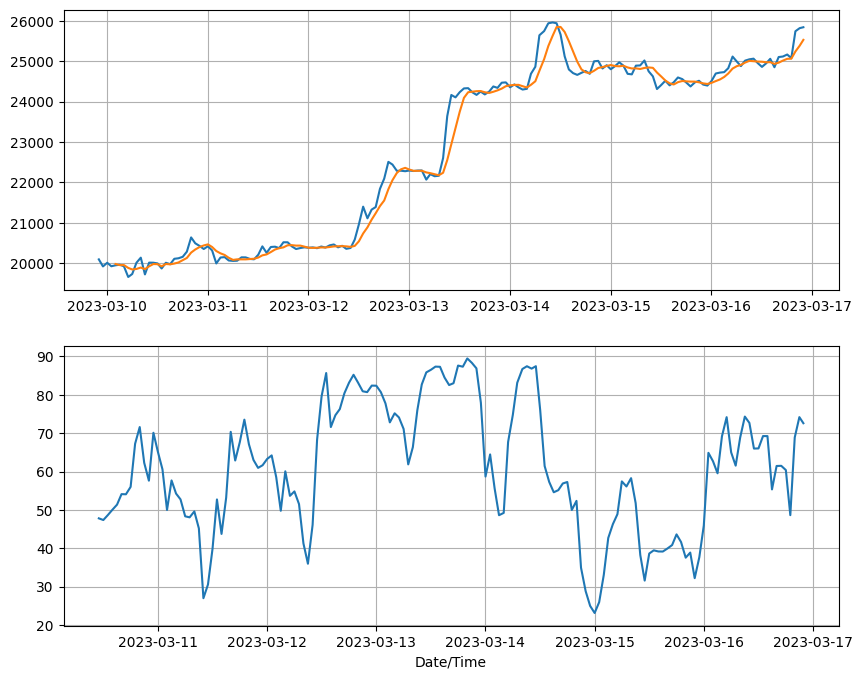

In [6]:
# plot price, moving average and rsi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))


ax1.plot(prices['local_dt'], prices['price'])
ax1.plot(prices['local_dt'], prices['ma'])
ax1.grid(True)

ax2.plot(prices['local_dt'], prices['rsi'])
ax2.grid(True)
ax2.set_xlabel('Date/Time')

plt.show()